In [1]:
import glob
print(glob.glob("/share/*"))

import torch
import faiss
from torch_cluster import knn_graph
from timeseries.timeseries_transformer import TimeseriesDataloader
from torch_cluster import knn
print(torch.cuda.is_available())
directory_path = '/share/us-stock-dataset/Data/Stocks'


['/share/Untitled.ipynb', '/share/us-stock-dataset', '/share/Transformers1']
True


In [2]:

stocks_to_load = [
    "AAPL", "TSLA",
    "A", "GOOG", "AMZN", "PYPL", "NVDA", "AMD",
    "NFLX", "MSFT", "INTC", "CSCO", "ADBE", "CRM", "QCOM", "TXN", "AVGO",
    "INTU", "ORCL", "COST", "SBUX", "AMGN", "CHTR", "GILD", "CMCSA", "BKNG",
    "MDLZ", "FISV", "BIIB", "MU", "MCD", "AMAT", "ADP", "ILMN", "ATVI", "ISRG",
    "ADSK", "LRCX", "BIDU", "JD", "REGN", "WBA", "VRTX", "KHC", "WMT", "ZM", "MELI",
    "TMUS", "CTSH", "XLNX", "PCAR", "ALGN", "WDAY", "SIRI", "CTXS", "ADI", "EXC", "LULU",
    "MAR", "KLAC", "PAYX", "EA", "ILMN", "ALXN", "MNST", "BMRN", "EBAY", "CTAS", "VRSK",
    "IDXX", "CDNS", "NXPI", "ASML", "INCY", "KLAC", "MCHP", "SNPS", "SWKS", "VRSN",
    "WDC", "WYNN", "XLNX", "ZBRA", "ZTS", "AEP", "AIG", "ALL", "AXP", "BA", "BAC",
    "BK", "BLK", "C", "CAT", "CL", "COF", "COP", "COST", "CSCO", "CVS", "CVX",
    "DD", "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE", "GILD",
    "GM", "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KHC", "KMI",
    "KO", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT", "MET", "MMM",
    'BLND', 'BLNG', 'BLNKW', 'BLNGU', 'BLNGW', 'BLNK', 'BLPH', 'BLRX',
    'BLTE', 'BLU', 'BLUA', 'BLUE', 'BLW', 'BLX', 'BLZE', 'BMA', 'BMAC', 'BMAQ', 'BMAQR', 'BMAQU'
]


In [3]:
dataloader = TimeseriesDataloader(directory_path, stocks_to_load, add_diff=False)

Reading and merging CSV files: ['AAPL', 'TSLA', 'A', 'GOOG', 'AMZN', 'PYPL', 'NVDA', 'AMD', 'NFLX', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'INTU', 'ORCL', 'COST', 'SBUX', 'AMGN', 'CHTR', 'GILD', 'CMCSA', 'BKNG', 'MDLZ', 'FISV', 'BIIB', 'MU', 'MCD', 'AMAT', 'ADP', 'ILMN', 'ATVI', 'ISRG', 'ADSK', 'LRCX', 'BIDU', 'JD', 'REGN', 'WBA', 'VRTX', 'KHC', 'WMT', 'ZM', 'MELI', 'TMUS', 'CTSH', 'XLNX', 'PCAR', 'ALGN', 'WDAY', 'SIRI', 'CTXS', 'ADI', 'EXC', 'LULU', 'MAR', 'KLAC', 'PAYX', 'EA', 'ILMN', 'ALXN', 'MNST', 'BMRN', 'EBAY', 'CTAS', 'VRSK', 'IDXX', 'CDNS', 'NXPI', 'ASML', 'INCY', 'KLAC', 'MCHP', 'SNPS', 'SWKS', 'VRSN', 'WDC', 'WYNN', 'XLNX', 'ZBRA', 'ZTS', 'AEP', 'AIG', 'ALL', 'AXP', 'BA', 'BAC', 'BK', 'BLK', 'C', 'CAT', 'CL', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'DD', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD'

In [4]:
data=dataloader.get_data().transpose(0, 1).cuda()
data.shape

torch.Size([145, 5283])

In [6]:
window_size = 10

def extract_sliding_windows(tensor, window_size):        
    windows = tensor.unfold(1, window_size, 1)
    return windows

sliding_windows=extract_sliding_windows(data, window_size)

print(sliding_windows.shape)

#sliding_windows=sliding_windows[:,0:10000,:]

print(sliding_windows.shape)

torch.Size([145, 5274, 10])
torch.Size([145, 5274, 10])


In [6]:
flat_sliding_windows = sliding_windows.reshape(-1, sliding_windows.size(2))
print(flat_sliding_windows.shape)


torch.Size([764730, 10])


In [56]:
def kmeans_sliding_windows(flat_windows, num_clusters=10000):
  
    windows_np = flat_windows.cpu().numpy()
    
    kmeans_model = faiss.Kmeans(flat_windows.size(1), num_clusters, niter=20, verbose=True)
    
    kmeans_model.train(windows_np)
    
    clustering_error = kmeans_model.obj[-1]  # Get the last objective value    

    n = flat_windows.shape[0]  # Number of data points
    mse = error / n
    rmse = mse ** 0.5

    _, cluster_assignment = kmeans_model.index.search(windows_np, 1)
    
    return torch.from_numpy(cluster_assignment.reshape(-1)), torch.from_numpy(kmeans_model.centroids), rmse

clusters, centroids, error = kmeans_sliding_windows(flat_sliding_windows)

print(centroids.shape)

print("Clustering error:", error)


Clustering 764730 points in 10D to 10000 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (558.27 s, search 557.88 s): objective=1.75101e+08 imbalance=9.382 nsplit=0       
torch.Size([10000, 10])
Clustering error: 0.004063608722451174


In [132]:
print(flat_sliding_windows.shape)

training_data = flat_sliding_windows[0:1000,:].unsqueeze(1) 
print(training_data.shape)

torch.Size([764730, 10])
torch.Size([1000, 1, 10])


In [5]:
training_data=data[:, 0:1000000].unsqueeze(1) 
print(training_data.shape)

torch.Size([145, 1, 5283])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, dim=256, emb_dim=256, kernel_size1=1, kernel_size2=8, dropout=0.1):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=emb_dim, kernel_size=kernel_size1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=emb_dim, out_channels=dim, kernel_size=kernel_size1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder().cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(training_data)
    
    # Compute the loss
    loss = loss_function(outputs, training_data)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 750.00 MiB (GPU 0; 11.76 GiB total capacity; 9.68 GiB already allocated; 52.56 MiB free; 10.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [88]:
fourier_transformed = torch.fft.fft(data, dim=1)##flat_sliding_windows

print(fourier_transformed.shape)  # Should be torch.Size([764730, 10])

# 1. Compute the magnitude of the Fourier coefficients
magnitude = torch.abs(fourier_transformed)

# 2. Standardize the magnitude data for correlation computation
magnitude_standardized = (magnitude - torch.mean(magnitude, dim=1, keepdim=True)) / torch.std(magnitude, dim=1, keepdim=True)

# 3. Compute the pairwise correlation matrix
correlation_matrix = torch.mm(magnitude_standardized, magnitude_standardized.T)
correlation_matrix /= magnitude.size(1)  # Normalize by the number of frequency components

print(correlation_matrix)


torch.Size([145, 5283])
torch.Size([145, 145])


In [89]:
# Sample tensor of shape [145, 5283]
stock_data = data

# Standardize the data
mean = torch.mean(stock_data, dim=1, keepdim=True)
std_dev = torch.std(stock_data, dim=1, keepdim=True)
stock_data_standardized = (stock_data - mean) / std_dev

# Compute the pairwise correlation matrix
correlation_matrix = torch.mm(stock_data_standardized, stock_data_standardized.T)
correlation_matrix /= stock_data.size(1)  # Normalize by the number of data points

print(correlation_matrix)


tensor([[0.9998, 0.8653, 0.9131,  ...,    nan, 0.3851,    nan],
        [0.8653, 0.9998, 0.7426,  ...,    nan, 0.1529,    nan],
        [0.9131, 0.7426, 0.9998,  ...,    nan, 0.4929,    nan],
        ...,
        [   nan,    nan,    nan,  ...,    inf,    nan,   -inf],
        [0.3851, 0.1529, 0.4929,  ...,    nan, 0.9998,    nan],
        [   nan,    nan,    nan,  ...,   -inf,    nan,    inf]],
       device='cuda:0')


OutOfMemoryError: CUDA out of memory. Tried to allocate 2178.60 GiB (GPU 0; 11.76 GiB total capacity; 189.92 MiB already allocated; 10.02 GiB free; 584.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
import matplotlib.pyplot as plt

def plot_tensor(dd, charts_per_row=6, num_rows=2):
    N = charts_per_row * num_rows  # Total number of charts
    plt.figure(figsize=(15, 5 * num_rows))
    
    for i in range(min(N, dd.size(0))):
        plt.subplot(num_rows, charts_per_row, i + 1)
        plt.plot(dd[i].cpu().numpy())
        plt.title(f"Cluster {i + 1}")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()



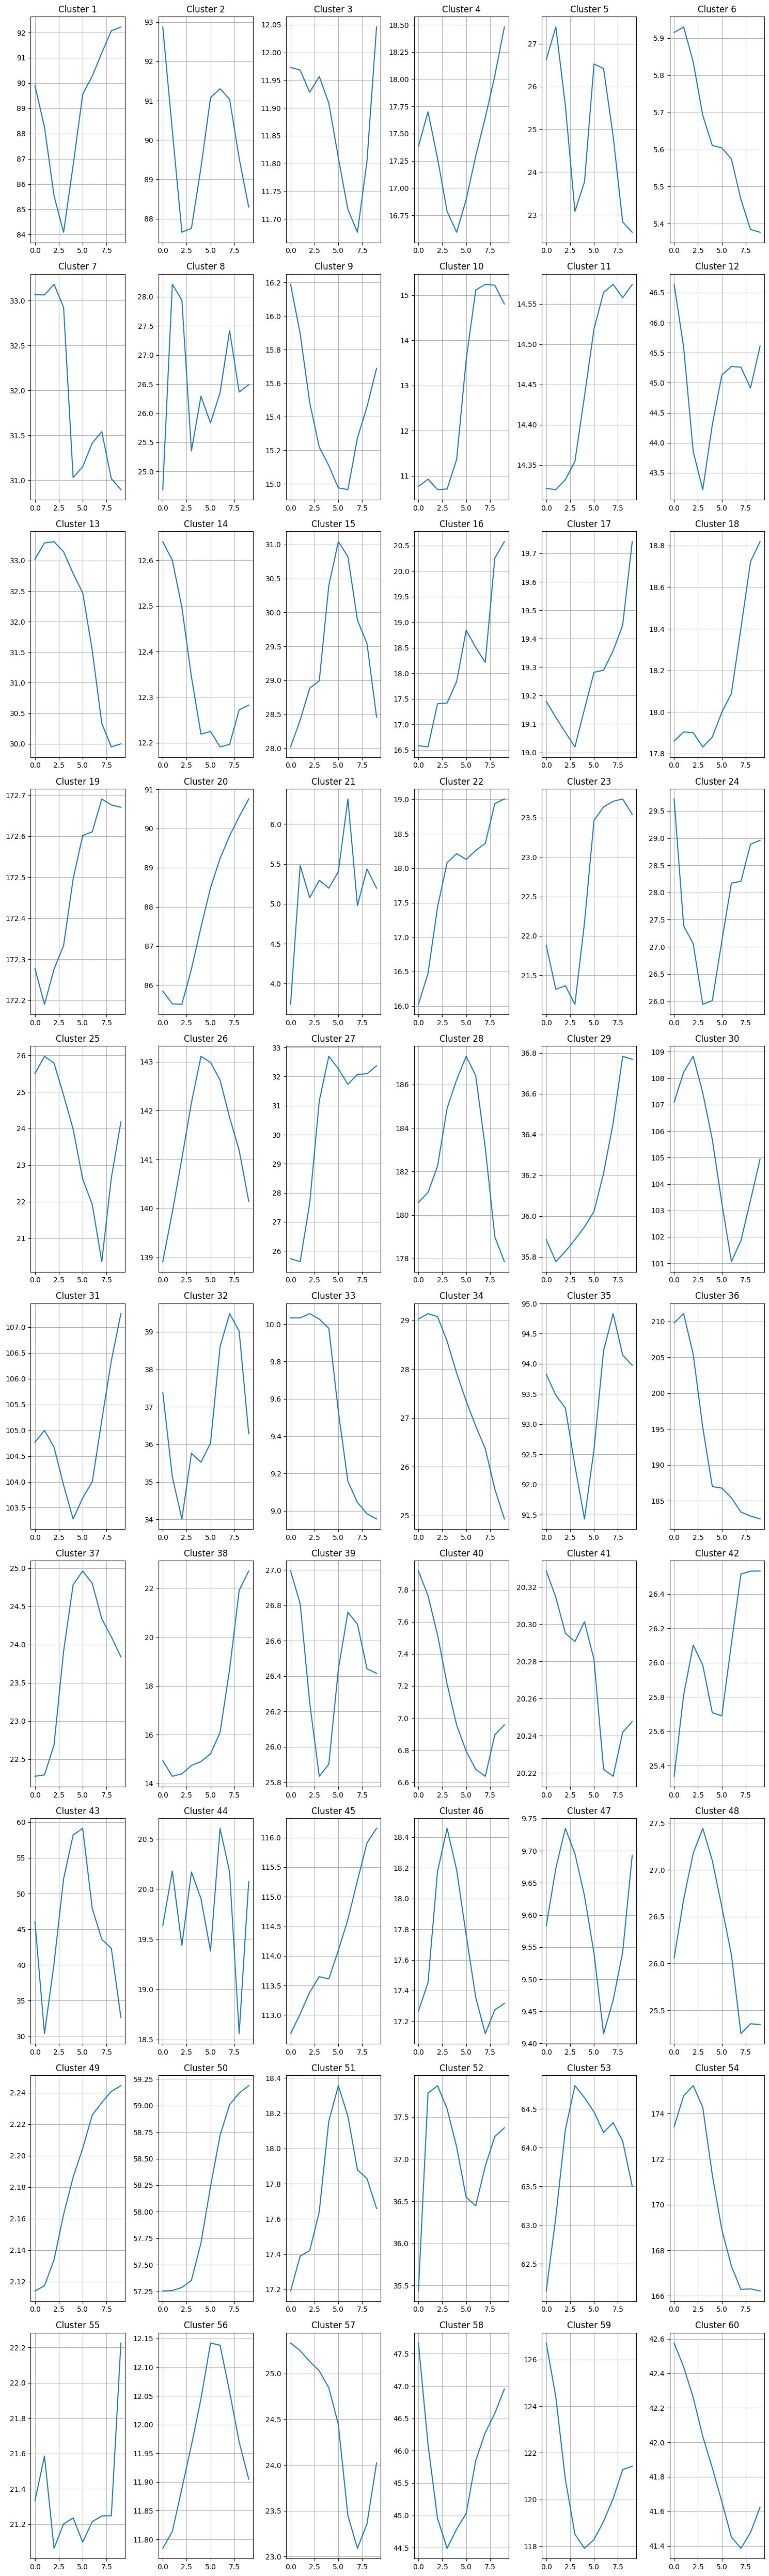

In [57]:
plot_tensor(centroids, num_rows=10)

In [ ]:
def knn_sliding_windows(data, k=5):
    data = data.cuda()
    
    return knn_graph(windows_reshaped, k=k, batch=None, loop=False)    

def kmeans_sliding_windows_gpu(flat_windows, num_clusters):   
    windows_np = flat_windows.cpu().numpy()
    d = flat_windows.size(1)
    
    res = faiss.StandardGpuResources()
    
    gpu_index = faiss.GpuIndexFlatL2(res, d)
    
    kmeans = faiss.Kmeans(d, num_clusters, niter=20, verbose=True, index=gpu_index)
    
    kmeans.train(windows_np)
    
    _, cluster_assignment = kmeans.index.search(windows_np, 1)
    
    return torch.from_numpy(cluster_assignment.reshape(-1)), torch.from_numpy(kmeans_model.centroids)


def kmeans_sliding_windows(flat_windows, num_clusters):   
  
    windows_np = flat_windows.cpu().numpy()
    
    kmeans_model = faiss.Kmeans(flat_windows.size(1), num_clusters, niter=20, verbose=True)
    
    kmeans_model.train(windows_np)
    
    _, cluster_assignment = kmeans_model.index.search(windows_np, 1)
    
    return torch.from_numpy(cluster_assignment.reshape(-1)), torch.from_numpy(kmeans_model.centroids)


def get_knn_representations(data, edge_index):
    num_points = data.size(0)
    k = edge_index.size(1) // num_points
    representations = []

    for i in range(num_points):
        # Get the indices of the k neighbors for the current data point
        neighbors = edge_index[1, i*k:(i+1)*k]
        # Compute the mean of the k neighbors
        mean_neighbors = torch.mean(data[neighbors], dim=0)
        representations.append(mean_neighbors)

    return torch.stack(representations)


num_clusters=100

knn_clusters = knn_sliding_windows(windows_reshaped, 5)
print(knn_clusters)

#kmeans_clusters, kmeans_centroids = kmeans_sliding_windows(windows_reshaped, num_clusters)
#print(kmeans_clusters)

#knn_representations = get_knn_representations(windows_reshaped, knn_clusters)


In [41]:
t = torch.tensor([[1,2,1,4],[2,3,4,9],[2,3,4,9],[2,3,4,9],[2,3,4,9],[2,3,4,9],[2,3,4,9],[2,3,4,9]])

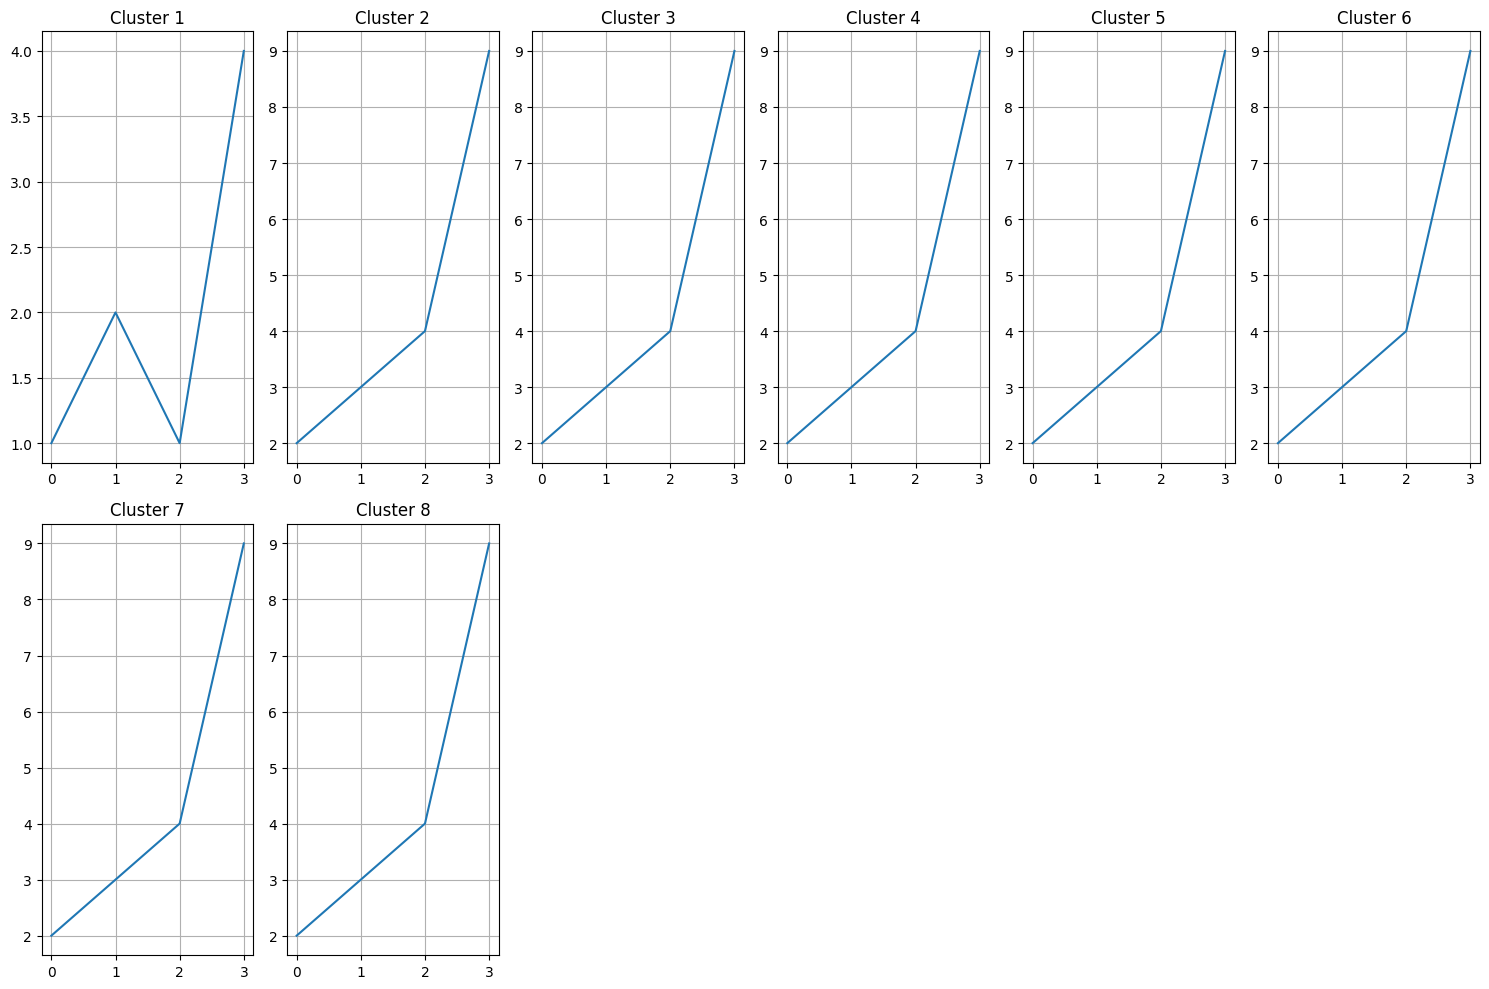

In [42]:
plot_cluster_representations(t)